# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [17]:
import os
import json
import skimage
from imgaug import augmenters as iaa
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [18]:
# import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [38]:
class PlatesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "plates"
    NUM_CLASSES = 1 + 1  # background + plate
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    LEARNING_RATE = 0.0002
    STEPS_PER_EPOCH = 200
    VALIDATION_STEPS = 50

#     IMAGE_RESIZE_MODE = "pad64"
#     IMAGE_MIN_DIM = 448 # None
    IMAGE_MAX_DIM = 1024
#     IMAGE_MIN_SCALE = None

#     MEAN_PIXEL = np.array([123.7, 116.8, 103.9]) TODO

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    # Non-max suppression threshold to filter RPN proposals.
    RPN_NMS_THRESHOLD = 0.8  # 0.7
    # Ratios of anchors at each cell (width/height)
    RPN_ANCHOR_RATIOS = [0.5, 1,  2]

    # Number of ROIs per image to feed to classifier/mask heads
    TRAIN_ROIS_PER_IMAGE = 256

    MAX_GT_INSTANCES = 5
    DETECTION_MAX_INSTANCES = 5
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.2  # 0.3


config = PlatesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        5
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.2
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                None
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0002
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preferences

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [40]:
class PlatesDataset(utils.Dataset):
    def load_plates(self, mode='train'):
        assert mode in ["train", "val"]

        self.add_class("plates", 1, "plate")

        if mode == 'train':
            dataset_dir = 'hard_plate_frames_train'
        else:
            dataset_dir = 'hard_plate_frames_test'
        files = set(os.listdir(dataset_dir))
        
        meta_file = json.load(open('hard_plate_frames.json'))
        annotations = list(sorted(meta_file['annotations'], key=lambda it: it['id']))
        images_info = list(sorted(meta_file['images'], key=lambda it: it['id']))
        assert len(annotations) == len(images_info), 'One2one annots2image is not satisfied'
        
        for annot, image in zip(annotations, images_info):
            if image['file_name'] not in files: 
                continue
            assert annot['id'] == image['id']
            
            self.add_image(
                "plates",
                image_id=image['id'], 
                path=os.path.join(dataset_dir, image['file_name']),
                width=image['width'],
                height=image['height'],
                polygons= np.reshape(np.array(annot['segmentation']), (-1, 2)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
            Returns:
                masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
                class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        xs = info["polygons"][:,0]
        ys = info["polygons"][:,1]
        
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        mask = np.zeros([info["height"], info["width"], 1], dtype=np.uint8)
        rr, cc = skimage.draw.polygon(ys, xs)
        mask[rr, cc, 0] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "plates":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [41]:
# Training dataset
dataset_train = PlatesDataset()
dataset_train.load_plates(mode='train')
dataset_train.prepare()

# Validation dataset
dataset_val = PlatesDataset()
dataset_val.load_plates(mode='val')
dataset_val.prepare()

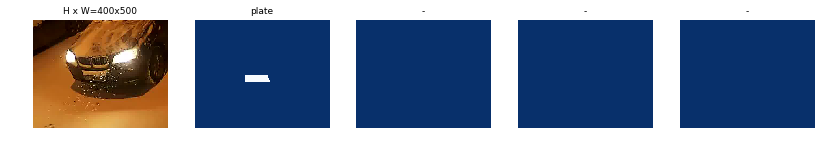

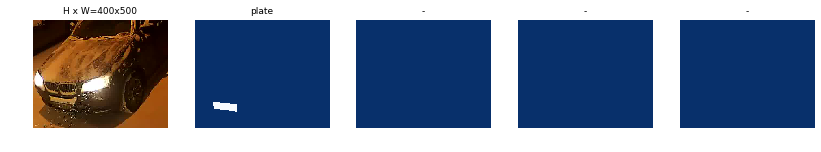

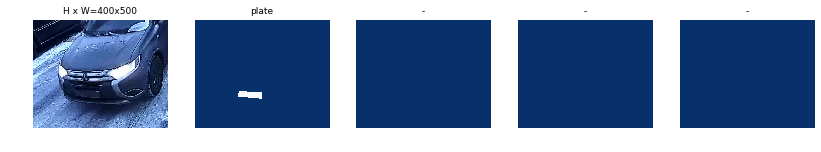

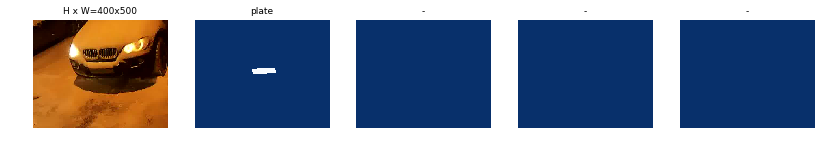

In [42]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [43]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [44]:
# Which weights to start with?
# init_with = "coco"  # imagenet, coco, or last
# init_with = 'last'
# init_with = 'init_nomeroff'
init_with = 'custom'

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    print('use', model.find_last())
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == 'init_nomeroff':
    path_init_nomeroff = '/nfs/home/rlebedev/frameworks/Mask_RCNN/logs/mask_rcnn_numberplate.h5' 
    print('use', path_init_nomeroff)
    model.load_weights(path_init_nomeroff, by_name=True)
elif init_with == 'custom':
#     model_path = '/nfs/home/rlebedev/frameworks/Mask_RCNN/logs/mask_rcnn_plates_0060.h5'
    model_path = '/nfs/home/rlebedev/frameworks/Mask_RCNN/logs/mask_rcnn_plates_0220.h5'
    model.load_weights(model_path, by_name=True)
    

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [45]:
augmentation = iaa.Sequential([
    iaa.Snowflakes(flake_size=(0.7, 0.95), speed=(0.001, 0.03)),
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.9, 1.1), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-15, 15),
        shear=(-5, 5)
    )
], random_order=True) # apply augmenters in random order

/nfs/home/rlebedev/venv/cuda10/lib/python3.5/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [46]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train,
            dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=400,
#             layers='heads',
            layers='4+',
            augmentation=augmentation)


Starting at epoch 0. LR=0.0002

Checkpoint Path: /nfs/home/rlebedev/frameworks/Mask_RCNN/logs/plates20200130T2044/mask_rcnn_plates_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_branch2c         

ERROR:root:Error processing image {'polygons': array([[319, 183],
       [394, 179],
       [392, 198],
       [318, 202]]), 'id': 229, 'path': 'hard_plate_frames_test/ch18_00136.jpg', 'height': 450, 'width': 800, 'source': 'plates'}
Traceback (most recent call last):
  File "/nfs/home/rlebedev/frameworks/Mask_RCNN/mrcnn/model.py", line 1772, in data_generator
    batch_images[b] = mold_image(image.astype(np.float32), config)
ValueError: could not broadcast input array from shape (512,832,3) into shape (448,576,3)ERROR:root:Error processing image {'polygons': array([[319, 183],
       [394, 179],
       [392, 198],
       [318, 202]]), 'id': 229, 'path': 'hard_plate_frames_test/ch18_00136.jpg', 'height': 450, 'width': 800, 'source': 'plates'}
Traceback (most recent call last):
  File "/nfs/home/rlebedev/frameworks/Mask_RCNN/mrcnn/model.py", line 1772, in data_generator
    batch_images[b] = mold_image(image.astype(np.float32), config)
ValueError: could not broadcast input array from sh

 79/200 [==========>...................] - ETA: 1:52 - loss: 0.7756 - rpn_class_loss: 0.5017 - rpn_bbox_loss: 0.2739 - mrcnn_class_loss: 4.8574e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

ValueError: could not broadcast input array from shape (448,576,3) into shape (512,832,3)

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=2, 
#             layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0021.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(PlatesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()
model_path = '/nfs/home/rlebedev/frameworks/Mask_RCNN/logs/plates20200129T0235/mask_rcnn_plates_0060.h5'

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
original_image = skimage.io.imread('voin_test.jpg')

In [ ]:
plt.imshow(original_image)

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Eval on validation

### 60

In [ ]:
for image_id in dataset_val.image_ids[:]:
    print(image_id)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
        dataset_val, inference_config, image_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=1)

    r = results[0]
    visualize.display_instances(original_image,
                                r['rois'],
                                r['masks'],
                                r['class_ids'],
                                dataset_val.class_names,
                                r['scores'],
                                ax=get_ax())
    plt.show()
    time.sleep(0.1)

### 260

In [ ]:
for image_id in dataset_val.image_ids[:]:
    print(image_id)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
        dataset_val, inference_config, image_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=1)

    r = results[0]
    visualize.display_instances(original_image,
                                r['rois'],
                                r['masks'],
                                r['class_ids'],
                                dataset_val.class_names,
                                r['scores'],
                                ax=get_ax())
    plt.show()
    time.sleep(0.1)

In [ ]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

# Tmp

In [ ]:
from PIL import ImageEnhance, Image


In [ ]:
# image = skimage.io.imread('hard_plate_frames_train/ch20_00013.jpg')
image = Image.open('hard_plate_frames_train/ch20_00013.jpg')


In [ ]:
def imshow(image):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

# imshow(skimage.exposure.rescale_intensity(image))
# imshow(skimage.exposure.equalize_hist(image))

enhancer = ImageEnhance.Contrast(image)
# enhancer = ImageEnhance.Brightness(image)

for i in range(12):
    factor = i / 2.0
    print(factor)
    imshow(enhancer.enhance(factor)) # .show("Sharpness %f" % factor))
